# Plotting Example: Covid-19 and Schools

**Author**

> - [Paul Schrimpf *UBC*](https://economics.ubc.ca/faculty-and-staff/paul-schrimpf/)  


**Prerequisites**

- [Visualization Rules](https://datascience.quantecon.org/visualization_rules.html)



**Outcomes**

-


**Data**

- Covid cases and deaths
- School district closure, opening, and policies


In [59]:
# Uncomment following line to install on colab
#! pip install 

In [60]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


%matplotlib inline

# Introduction

In a recent article, ["The association of opening K–12 schools with the spread of COVID-19 in the United States: County-level panel data analysis", Chernozhukov, Kasahara, and Schrimpf (2021)](https://doi.org/10.1073/pnas.2103420118) present evidence that opening schools for in-person learning may have increased the spread of Covid-19, especially where schools did not require masks. 

The paper uses data on US counties from April 2020 to December 2020. This notebook will examine whether the paper's findings hold in more recent data.

More specifically, we will recreate panels A and B of Figure 1 from the paper.

![Figure 1](https://www.pnas.org/content/pnas/118/42/e2103420118/F1.large.jpg)

# Data 

We will use data from three sources.

1. County level cases and deaths from the [NYTimes git repository](https://github.com/nytimes/covid-19-data/tree/master/rolling-averages).
2. School district openings, closures, and Covid policies from [MCH Strategic data](https://www.mchdata.com/covid19/schoolclosings)
3. Matching between school districts and counties from the [US Census Bureau](https://www2.census.gov/programs-surveys/saipe/guidance-geographies/districts-counties/)

## Cases and Deaths

In [61]:
try : # don't redownload if cases already exists
  cases
except :
  cases = pd.concat(
    [pd.read_csv('https://github.com/nytimes/covid-19-data/raw/master/rolling-averages/us-counties-2020.csv'),
     pd.read_csv('https://github.com/nytimes/covid-19-data/raw/master/rolling-averages/us-counties-2021.csv')], 
    axis=0
    )

cases.head()

,date,geoid,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k,fips
0,2020-01-21,USA-53061,Snohomish,Washington,1,0.14,0.02,0,0.0,0.0,53061
1,2020-01-22,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0,53061
2,2020-01-23,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0,53061
3,2020-01-24,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0,53061
4,2020-01-24,USA-17031,Cook,Illinois,1,0.14,0.00,0,0.0,0.0,17031


For mergeing this data with the other data sources, we will County FIPS codes. The `geoid` column contains the county FIPS codes preceded by "USA-". Let's extract the FIPS codes.

In [62]:
cases['fips'] = pd.to_numeric(cases['geoid'].str[4:])

## School Policies

In [63]:
# 2020 data 
try :
  mch2020
except: 
  mch2020 = pd.read_csv('https://github.com/ubcecon/covid-schools/raw/master/data/covid-school-data.csv')

mch2020.head()

,SchoolYear,DistrictNCES,DistrictID,DistrictName,Control,PhysicalCity,PhysicalState,Enrollment,OpenDate,TeachingMethod,...,OnlineInstructionIncrease,NetworkInvestment,HardwareInvestment,StaffMaskPolicy,StudentMaskPolicy,StudentIllnessReturnPolicy,StudentIsolationArea,SchoolTemporaryShutdown,ParentOptOutClassroomTeaching,LastVerifiedDate
0,2020-2021,200004.0,888659,Yupiit School District,Public,Akiachak,AK,463.0,08/12/2020,Online Only,...,No,No,No,Required for all staff,Required for all students,Yes,No,Closed indefinitely,Yes,01/11/2021
1,2020-2021,NaN,2442904,Alaska Conference of SDA Education Dept,Private,Anchorage,AK,NaN,09/08/2020,Hybrid,...,No,Unknown,Unknown,Required for all staff,Required for all students,Yes,Unknown,Never closed,Unknown,11/09/2020
2,2020-2021,200010.0,888610,Aleutian Region School District,Public,Anchorage,AK,27.0,09/08/2020,On Premises,...,Unknown,Yes,Yes,Required for all staff,Required for all students,Unknown,Unknown,Never closed,Yes,11/30/2020
3,2020-2021,200180.0,888658,Anchorage School District,Public,Anchorage,AK,48347.0,08/25/2020,Online Only,...,Pending,Pending,Pending,Pending,Pending,Pending,Pending,Pending,Unknown,12/28/2020
4,2020-2021,200800.0,888657,Chugach School District,Public,Anchorage,AK,517.0,08/17/2020,Online Only,...,Yes,Unknown,Unknown,Required for all staff,Required for all students,Yes,Yes,Closed 6-14 days,Yes,01/04/2021


In [64]:
mch2020.columns

Index(['SchoolYear', 'DistrictNCES', 'DistrictID', 'DistrictName', 'Control',
       'PhysicalCity', 'PhysicalState', 'Enrollment', 'OpenDate',
       'TeachingMethod', 'SportsParticipation', 'OnlineInstructionIncrease',
       'NetworkInvestment', 'HardwareInvestment', 'StaffMaskPolicy',
       'StudentMaskPolicy', 'StudentIllnessReturnPolicy',
       'StudentIsolationArea', 'SchoolTemporaryShutdown',
       'ParentOptOutClassroomTeaching', 'LastVerifiedDate'],
      dtype='object')

In [65]:
# 2021
try :
  mch2021
except : # reading from excel takes a bit of time, so only do it once
  mch2021 = pd.read_excel('covid-school-data-fall2021.xlsx')
mch2021.head()

,SchoolYear,DistrictNCES,DistrictID,DistrictName,Control,PhysicalCity,PhysicalState,Enrollment,TeachingMethod,ElementaryTeachingOnPremise,...,SchoolVaccinationClinic,ExtracurricularParticipation,ExtracurricularPreventionMask,ExtracurricularPreventionTesting,ExtracurricularPreventionDistance,ExtracurricularPreventionVaccination,ExtracurricularPreventionVentilation,ExtracurricularPreventionHandwashing,ExtracurricularPreventionNone,LastVerifiedDate
0,2021-2022,200004.0,888659,Yupiit School District,Public,Akiachak,AK,453.0,Full In-Person,Yes,...,Pending,Pending,Pending,Pending,Pending,Pending,Pending,Pending,Pending,10/12/2021
1,2021-2022,200010.0,888610,Aleutian Region School District,Public,Anchorage,AK,27.0,Full In-Person,Yes,...,No,No,Pending,Pending,Pending,Pending,Pending,Pending,Pending,10/14/2021
2,2021-2022,200180.0,888658,Anchorage School District,Public,Anchorage,AK,48211.0,Other,Yes,...,Yes,Yes,Yes,Pending,Yes,Pending,Pending,Pending,Pending,10/14/2021
3,2021-2022,200800.0,888657,Chugach School District,Public,Anchorage,AK,514.0,Hybrid/Partial,Pending,...,No,Yes,Pending,Pending,Pending,Yes,Pending,Pending,Pending,10/14/2021
4,2021-2022,200730.0,888599,Chatham School District,Public,Angoon,AK,143.0,Pending,Pending,...,Pending,Pending,Pending,Pending,Pending,Pending,Pending,Pending,Pending,NaN


In [66]:
mch2021.columns

Index(['SchoolYear', 'DistrictNCES', 'DistrictID', 'DistrictName', 'Control',
       'PhysicalCity', 'PhysicalState', 'Enrollment', 'TeachingMethod',
       'ElementaryTeachingOnPremise', 'ElementaryTeachingHybrid',
       'ElementaryTeachingRemoteOnline', 'ElementaryTeachingUnknown',
       'ElementaryTeachingOther', 'MiddleTeachingOnPremise',
       'MiddleTeachingHybrid', 'MiddleTeachingRemoteOnline',
       'MiddleTeachingUnknown', 'MiddleTeachingOther', 'HighTeachingOnPremise',
       'HighTeachingHybrid', 'HighTeachingRemoteOnline', 'HighTeachingUnknown',
       'HighTeachingOther', 'ParentOptOutClassroomTeaching',
       'StudentAllRemotePercent', 'TeachingMethodJan2021',
       'TeachingMethodLastMonth2021', 'StaffCovidTesting',
       'StudentCovidTesting', 'SportsParticipation', 'StaffMaskPolicy',
       'ElementaryStudentMaskPolicy', 'MiddleStudentMaskPolicy',
       'HighStudentMaskPolicy', 'SchoolYearStartDate',
       'SchoolYearStaggeredStart', 'SocialDistancingPolicy',


In [67]:
mch2021.StaffMaskPolicy.value_counts()

Yes                                             6550
Pending                                         4969
Not required                                    4426
Unknown                                          640
Required for unvaccinated teachers and staff     175
Name: StaffMaskPolicy, dtype: int64

Let's make a figure to summarize how school policies changed from 2020 to 2021. 

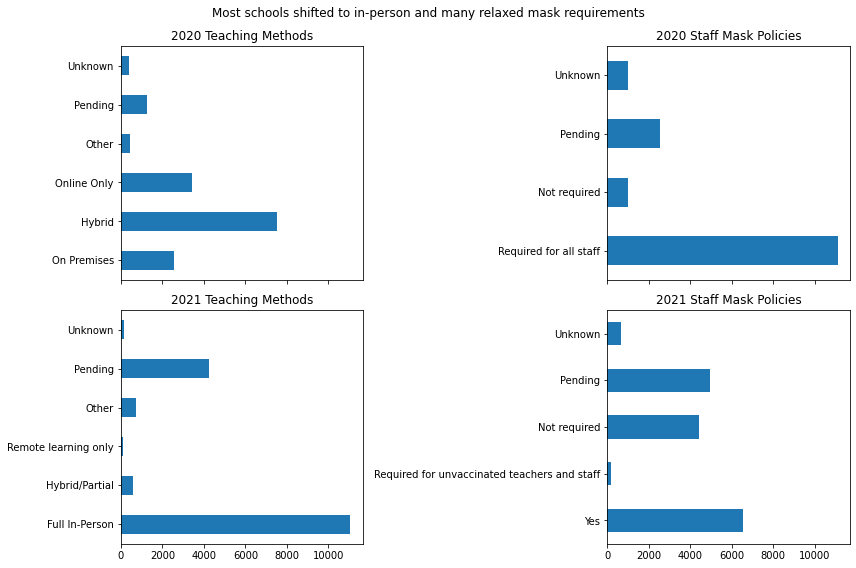

In [68]:
fig, ax = plt.subplots(2,2, figsize=(12,8), sharex=True)

mch2020.TeachingMethod.value_counts()[['On Premises','Hybrid','Online Only','Other','Pending','Unknown']].plot(kind='barh', ax=ax[0,0])
ax[0,0].set_title('2020 Teaching Methods')

mch2020.StaffMaskPolicy.value_counts()[['Required for all staff','Not required','Pending','Unknown']].plot(kind='barh', ax=ax[0,1])
ax[0,1].set_title('2020 Staff Mask Policies')

mch2021.TeachingMethod.value_counts()[['Full In-Person','Hybrid/Partial','Remote learning only','Other','Pending','Unknown']].plot(kind='barh', ax=ax[1,0])
ax[1,0].set_title('2021 Teaching Methods')
mch2021.StaffMaskPolicy.value_counts()[['Yes','Required for unvaccinated teachers and staff','Not required','Pending','Unknown']].plot(kind='barh', ax=ax[1,1])
ax[1,1].set_title('2021 Staff Mask Policies')

fig.suptitle('Most schools shifted to in-person and many relaxed mask requirements')
fig.tight_layout()

This figure remains a work-in-progress. It has some good things and some bad. On the plus side, the title and contents have a clear message. However, the formatting could be improved. The labels are different for the two years. Colors could be used to highlight the different type of information in the two columns. This layout might not be best. Maybe it would be better as two figures with two subplots each instead of one figure with four subplots.

## School district to County FIPS Mapping



In [69]:
# you might have to install xlrd
# !pip install xlrd 
try :
  sdlist
except :  
  sdlist = pd.read_excel('https://www2.census.gov/programs-surveys/saipe/guidance-geographies/districts-counties/sdlist-20.xls', 
                        skiprows=2)
# combing state and county fips to a single 5 digit fips code
sdlist['fips'] = sdlist['State FIPS']*1000 + sdlist['County FIPS']
# combine state fips and district id to get district NCES
sdlist['NCES'] = sdlist['State FIPS']*100_000 + sdlist['District ID Number']

sdlist.head()

,State Postal Code,State FIPS,District ID Number,School District Name,County Names,County FIPS,fips,NCES
0,AL,1,190,Alabaster City School District,Shelby County,117,1117,100190
1,AL,1,5,Albertville City School District,Marshall County,95,1095,100005
2,AL,1,30,Alexander City City School District,Tallapoosa County,123,1123,100030
3,AL,1,60,Andalusia City School District,Covington County,39,1039,100060
4,AL,1,90,Anniston City School District,Calhoun County,15,1015,100090


# Merge Data

Many counties contain multiple school districts, and some school districts contain multiple counties. This makes combining the school district data with the county level case data slightly complicated.

We will first combine the MCH school district data with the county FIPS codes from the census. Then for each county, we will compute county level school variables as the enrollment weighted average (or some other appropriate aggregate) of the variable for the school districts in that county.

## School Districts to Counties


### 2020

In [70]:
s20 = pd.merge(mch2020, sdlist, left_on="DistrictNCES", right_on="NCES", how='right')

For each county, we compute the portion of students enrolled in 'Hybrid', 'Online', 'In-Person', and 'Unknown' teaching method school districts.

In [71]:
def weighted_portions(df, x, w) :
  """
  Return the weighted by `w` portion in each category of `x`
  """
  res = df.groupby(x)[w].sum() / df[w].sum()
  return(res)

In [72]:
teaching = s20.groupby('fips').apply(weighted_portions,'TeachingMethod','Enrollment').unstack()
teaching.rename({'On Premises':'In-Person','Online Only':'Online'},axis=1, inplace=True)
teaching.replace(np.nan, 0.0, inplace=True)
teaching['Teaching Unknown'] = teaching['Other'] + teaching['Pending'] + teaching['Unknown']
teaching.drop(['Unknown','Other','Pending'], axis=1, inplace=True)
teaching['Year']=2020

Similarly, for each county we compute the portion of students in school districts with and without staff mask requirements. 

In [73]:
mask = s20.groupby('fips').apply(weighted_portions,'StaffMaskPolicy','Enrollment').unstack()
mask.replace(np.nan, 0.0, inplace=True)
mask.rename({'Required for all staff':'Masks required for staff','Not required':'Masks not required for staff'},axis=1,inplace=True)
mask['Masks unknown for staff'] = mask['Pending'] + mask['Unknown']
mask.drop(['Pending','Unknown'],axis=1,inplace=True)
mask['Year']=2020

Finally, for each county we calculate the enrollment weighted average school start date.

In [74]:
def weighted_average_date(dates, weight, basedate=pd.to_datetime('2020-01-01')):
  """
  Return the weighted average of the values in `dates`
  """
  days = (dates - basedate).dt.days
  if all(np.isnan(days)):
    return(pd.NaT)
  weight[np.isnan(days)] = 0
  days.fillna(0, inplace=True)
  weight.fillna(0, inplace=True)
  avgday = np.average(days, weights=weight)
  return(basedate + pd.Timedelta(days=avgday))
  
s20['OpenDate'] = pd.to_datetime(s20['OpenDate'])
opening = s20.groupby('fips').apply(lambda x: weighted_average_date(x.OpenDate, weight=x.Enrollment))
opening.name = 'OpeningDate'

In [75]:
countyschool = pd.merge(teaching,mask, on=['fips','Year']).join(opening)

This `countyschool` data frame now has county level school opening and mask policies for 2020. 

### 2021

We now repeat similar steps to get county level school opening and mask policies for 2021. 

In [76]:
s21 = pd.merge(mch2021, sdlist, left_on="DistrictNCES", right_on="NCES", how='right')

In [77]:
teaching = s21.groupby('fips').apply(weighted_portions,'TeachingMethod','Enrollment').unstack()
teaching.rename({'Full In-Person':'In-Person','Hybrid/Partial':'Hybrid','Remote learning only':'Online'}, axis=1, inplace=True)
teaching.replace(np.nan, 0.0, inplace=True)
teaching['Teaching Unknown'] = teaching['Other'] + teaching['Pending'] + teaching['Unknown']
teaching.drop(['Unknown','Other','Pending'], axis=1, inplace=True)
teaching['Year']=2021

In [78]:
mask = s21.groupby('fips').apply(weighted_portions,'StaffMaskPolicy','Enrollment').unstack()
mask.replace(np.nan, 0.0, inplace=True)
mask.rename({'Yes':'Masks required for staff','Not required':'Masks not required for staff'},axis=1,inplace=True)
mask['Masks unknown for staff'] = mask['Pending'] + mask['Unknown']
mask.drop(['Pending','Unknown'],axis=1,inplace=True)
mask['Year']=2021

In [79]:
s21['OpenDate'] = pd.to_datetime(s21['SchoolYearStartDate'])
opening = s21.groupby('fips').apply(lambda x: weighted_average_date(x.OpenDate, weight=x.Enrollment))
opening.name = 'OpeningDate'

In [80]:
countyschool21 = pd.merge(teaching,mask, on=['fips','Year']).join(opening)

# Creating the Figure

# 2020

We're now ready to create the figure. First, combine the county level school data with the case and death data.

In [81]:
cases['date'] = pd.to_datetime(cases['date'])
df = pd.merge(countyschool, cases, on='fips')
df['DaysOpen'] = (df['date'] - df['OpeningDate']).dt.days

In [82]:
df.columns

Index(['fips', 'Hybrid', 'In-Person', 'Online', 'Teaching Unknown', 'Year',
       'Masks not required for staff', 'Masks required for staff',
       'Masks unknown for staff', 'OpeningDate', 'date', 'geoid', 'county',
       'state', 'cases', 'cases_avg', 'cases_avg_per_100k', 'deaths',
       'deaths_avg', 'deaths_avg_per_100k', 'DaysOpen'],
      dtype='object')

Now we want to compute the average cases conditional on the number of days schools have been open, school teaching method, and staff mask policy. If teaching method and mask policy were discrete variables, this would be straightforward. However, teaching method and mask policy at the county level are portions. There are a number of reasonable things we could do to get discrete conditional means. One approach would be to classify counties as "In-Person" / "Hybrid" / "Online" based on which portion is highest. This is how the figure in Chernozhukov, Kasahara, and Schrimpf (2021) was created. 

Here, we will take a slightly different, but also reasonable, approach. We will estimate a regression of cases on teaching method portions interacted with staff mask portions and number of days open. Linear regressions give linear approximations to conditional expectations, so the predicted values from the regression will be close to conditional averages. In fact, if the teaching method and mask variables were discrete, the regression we will fit would give the exact conditional averages. 

*Warning:* Since there are a large number of county-days, this regression takes some computer resources. Trying to run this notebook on ubc.syzygy.ca might be a bad idea. Using [Google Colab](https://colab.research.google.com/) should work.

In [83]:
import statsmodels.formula.api as smf
mdf = df.query("DaysOpen>=-30 and DaysOpen<=90 and `Teaching Unknown`<0.1 and `Masks unknown for staff`<0.5")
mod = smf.ols(formula='cases_avg_per_100k ~ (Hybrid + Q("In-Person"))*Q("Masks required for staff")*C(DaysOpen)', 
              data=mdf)

In [84]:
res = mod.fit(cov_type='cluster', cov_kwds={'groups': mdf['fips']}) 

Now we want the predicted values from this regression for a county with fully "In-Person" (and fully "Hybrid" and "Online") teaching. We create a data frame to make these predictions.

In [85]:
fdf = pd.DataFrame({'DaysOpen':range(-30,91),})
fdf['Hybrid'] = 0.0
fdf['In-Person'] = 0.0
fdf['Masks required for staff'] = 0.0
fdf['group'] = 'Online'

ndf = fdf.copy()
ndf['Hybrid'] = 1.0
ndf['group'] = 'Hybrid, No Mask'
sdf = pd.concat([fdf,ndf])

ndf = fdf.copy()
ndf['Hybrid'] = 1.0
ndf['Masks required for staff'] = 1.0
ndf['group'] = 'Hybrid, Yes Mask'
sdf = pd.concat([sdf,ndf])

ndf = fdf.copy()
ndf['In-Person'] = 1.0
ndf['Masks required for staff'] = 1.0
ndf['group'] = 'In-Person, Yes Mask'
sdf = pd.concat([sdf,ndf])

ndf = fdf.copy()
ndf['In-Person'] = 1.0
ndf['Masks required for staff'] = 0.0
ndf['group'] = 'In-Person, No Mask'
sdf = pd.concat([sdf,ndf])
sdf = sdf.reset_index().drop('index',axis=1)


Now compute the predicted cases for this data frame.

In [86]:
pred = res.get_prediction(sdf) # predicted mean cases
sdf20 = sdf.join(pred.summary_frame(alpha=0.05)) # get standard errors and confidence intervals

Now we can create the figure. Along with average cases we can show 95\% confidence intervals. 

Text(0.5, 1.0, 'Avereage Cases Conditional on Teaching Method and Staff Mask  in 2020')

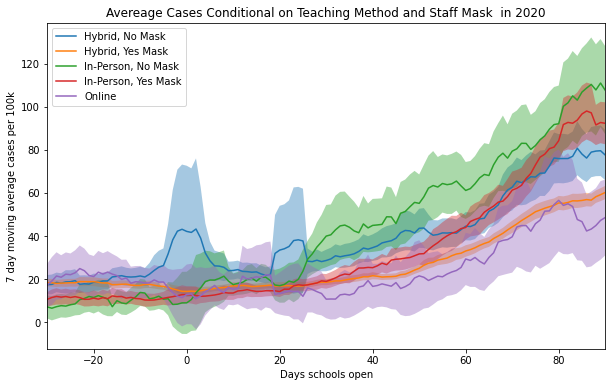

In [87]:
fig,ax = plt.subplots(figsize=(10,6))
for name, g in sdf20.groupby('group'):
  ax.plot(g.DaysOpen, g['mean'], label=name)
  ax.fill_between(g.DaysOpen, g['mean_ci_lower'], g['mean_ci_upper'], alpha=0.4) #, label=name)

ax.legend()
ax.set_xlim((-30,90))
ax.set_xlabel("Days schools open")
ax.set_ylabel("7 day moving average cases per 100k")
ax.set_title("Avereage Cases Conditional on Teaching Method and Staff Mask  in 2020")

The figure looks similar to the one in the paper. As mentioned above, the method of calculating conditional averages is slightly different here. Also, the units on the y-axis differ. However, the qualitative conclusions are unchanged. 

## 2021

We now repeat the above for the 2021 school year.

In [88]:
df = pd.merge(countyschool21, cases, on='fips')
df['DaysOpen'] = (df['date'] - df['OpeningDate']).dt.days

In [89]:
mdf = df.query("DaysOpen>=-30 and DaysOpen<=90 and `Teaching Unknown`<0.1 and `Masks unknown for staff`<0.5")
mod = smf.ols(formula='cases_avg_per_100k ~ (Hybrid + Q("In-Person"))*Q("Masks required for staff")*C(DaysOpen)', 
              data=mdf)

In [90]:
res = mod.fit(cov_type='cluster', cov_kwds={'groups': mdf['fips']}) 

In [91]:
fdf = pd.DataFrame({'DaysOpen':range(-30,91),})
fdf['Hybrid'] = 0.0
fdf['In-Person'] = 0.0
fdf['Masks required for staff'] = 0.0
fdf['group'] = 'Online'

ndf = fdf.copy()
ndf['Hybrid'] = 1.0
ndf['group'] = 'Hybrid, No Mask'
sdf = pd.concat([fdf,ndf])

ndf = fdf.copy()
ndf['Hybrid'] = 1.0
ndf['Masks required for staff'] = 1.0
ndf['group'] = 'Hybrid, Yes Mask'
sdf = pd.concat([sdf,ndf])

ndf = fdf.copy()
ndf['In-Person'] = 1.0
ndf['Masks required for staff'] = 1.0
ndf['group'] = 'In-Person, Yes Mask'
sdf = pd.concat([sdf,ndf])

ndf = fdf.copy()
ndf['In-Person'] = 1.0
ndf['Masks required for staff'] = 0.0
ndf['group'] = 'In-Person, No Mask'
sdf = pd.concat([sdf,ndf])
sdf = sdf.reset_index().drop('index',axis=1)


In [92]:
pred = res.get_prediction(sdf)
sdf21 = sdf.join(pred.summary_frame(alpha=0.05))

Text(0.5, 1.0, 'Avereage Cases Conditional on Teaching Method and Staff Mask Policy in 2021')

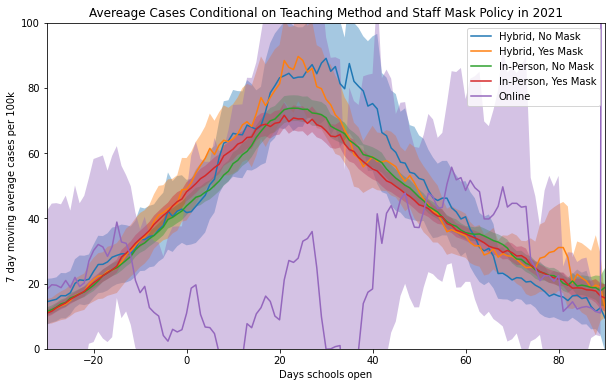

In [93]:
fig,ax = plt.subplots(figsize=(10,6))
for name, g in sdf21.groupby('group'):
  ax.plot(g.DaysOpen, g['mean'], label=name)
  ax.fill_between(g.DaysOpen, g['mean_ci_lower'], g['mean_ci_upper'], alpha=0.4) #, label=name)

ax.legend()
ax.set_xlim((-30,90))
ax.set_ylim((0,100))
ax.set_xlabel("Days schools open")
ax.set_ylabel("7 day moving average cases per 100k")
ax.set_title("Avereage Cases Conditional on Teaching Method and Staff Mask Policy in 2021")

This figure looks quite different in 2021. Since "Online" and, to a lesser extent, "Hybrid" teaching is rare, those conditional averages are very noisy. We could have anticipated this problem from the bar chart that we created earlier. 

Let's recreate the figure without the "Online" group.

Text(0.5, 1.0, 'Avereage Cases Conditional on Teaching Method and Staff Mask Policy in 2021')

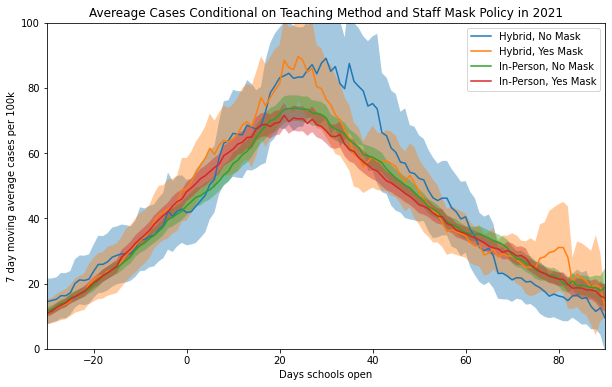

In [94]:
fig,ax = plt.subplots(figsize=(10,6))
for name, g in sdf21.groupby('group'):
  if name == "Online" : 
    continue
  ax.plot(g.DaysOpen, g['mean'], label=name)
  ax.fill_between(g.DaysOpen, g['mean_ci_lower'], g['mean_ci_upper'], alpha=0.4) #, label=name)

ax.legend()
ax.set_xlim((-30,90))
ax.set_ylim((0,100))
ax.set_xlabel("Days schools open")
ax.set_ylabel("7 day moving average cases per 100k")
ax.set_title("Avereage Cases Conditional on Teaching Method and Staff Mask Policy in 2021")

That looks a little cleaner. There doesn't appear to be any relationship between cases and teaching method or staff mask policy. 